<a href="https://colab.research.google.com/github/SiddhantKumar2211/Human-Activity-Recognisation-Machine-Learning-/blob/main/Human_Activity_Recognisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Fri May  5 15:00:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# New Section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!rm -rf /content/*
!pip install --upgrade --no-cache-dir gdown
# https://drive.google.com/file/d/1JGrBHwtTZY0wp9EbsQ-uiD5D9QirNaZ6/view?usp=sharing
!gdown https://drive.google.com/uc?id=1JGrBHwtTZY0wp9EbsQ-uiD5D9QirNaZ6
!unzip "/content/DCSASS Dataset.zip"
!rm -rf "/content/DCSASS Dataset.zip"
!mv "/content/DCSASS Dataset/Labels" /content/Labels

Streaming output truncated to the last 5000 lines.
  inflating: DCSASS Dataset/Robbery/Robbery150_x264.mp4/Robbery150_x264_26.mp4  
  inflating: DCSASS Dataset/Robbery/Robbery150_x264.mp4/Robbery150_x264_27.mp4  
  inflating: DCSASS Dataset/Robbery/Robbery150_x264.mp4/Robbery150_x264_28.mp4  
  inflating: DCSASS Dataset/Robbery/Robbery150_x264.mp4/Robbery150_x264_29.mp4  
  inflating: DCSASS Dataset/Robbery/Robbery150_x264.mp4/Robbery150_x264_3.mp4  
  inflating: DCSASS Dataset/Robbery/Robbery150_x264.mp4/Robbery150_x264_30.mp4  
  inflating: DCSASS Dataset/Robbery/Robbery150_x264.mp4/Robbery150_x264_31.mp4  
  inflating: DCSASS Dataset/Robbery/Robbery150_x264.mp4/Robbery150_x264_4.mp4  
  inflating: DCSASS Dataset/Robbery/Robbery150_x264.mp4/Robbery150_x264_5.mp4  
  inflating: DCSASS Dataset/Robbery/Robbery150_x264.mp4/Robbery150_x264_6.mp4  
  inflating: DCSASS Dataset/Robbery/Robbery150_x264.mp4/Robbery150_x264_7.mp4  
  inflating: DCSASS Dataset/Robbery/Robbery150_x264.mp4/Robbery

In [ ]:
import pandas as pd

def filter_df(path):
    df = pd.read_csv(path,names=['file_name', 'label','class'])
    df['file_name'] = df['file_name'].apply(lambda x:x+'.mp4')
    df = df[df['class'] == 1]
    file_names = df['file_name'].unique().tolist()
    return file_names

In [ ]:
import os
from tqdm.auto import tqdm
old_folder = os.path.join('/content','DCSASS Dataset')
labels_files = os.path.join('/content','Labels')
file_paths = {}

for i in tqdm(os.listdir(old_folder)):
    l1 = os.listdir(os.path.join(old_folder,i))
    path = os.path.join(labels_files,i+'.csv')
    files = filter_df(path)
    file_paths[i] = []
    for j in l1:
        l2 = os.listdir(os.path.join(old_folder,i,j))
        for k in l2:
            if k in files:
                file_paths[i].append(os.path.join(old_folder,i,j,k))

  0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
!rm -rf video_data
!mkdir video_data

In [ ]:
new_folder = os.path.join('/content','video_data')
th = 50

for i,j in tqdm(file_paths.items()):
    os.mkdir(os.path.join(new_folder,i))
    for idx,k in enumerate(j):
        file_name = k.split('/')[-1]
        dest_path = os.path.join(new_folder,i,file_name)
        os.rename(k,dest_path)
        if (idx+1) == th:
            break

  0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
!rm -rf "/content/DCSASS Dataset" /content/Labels

In [ ]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

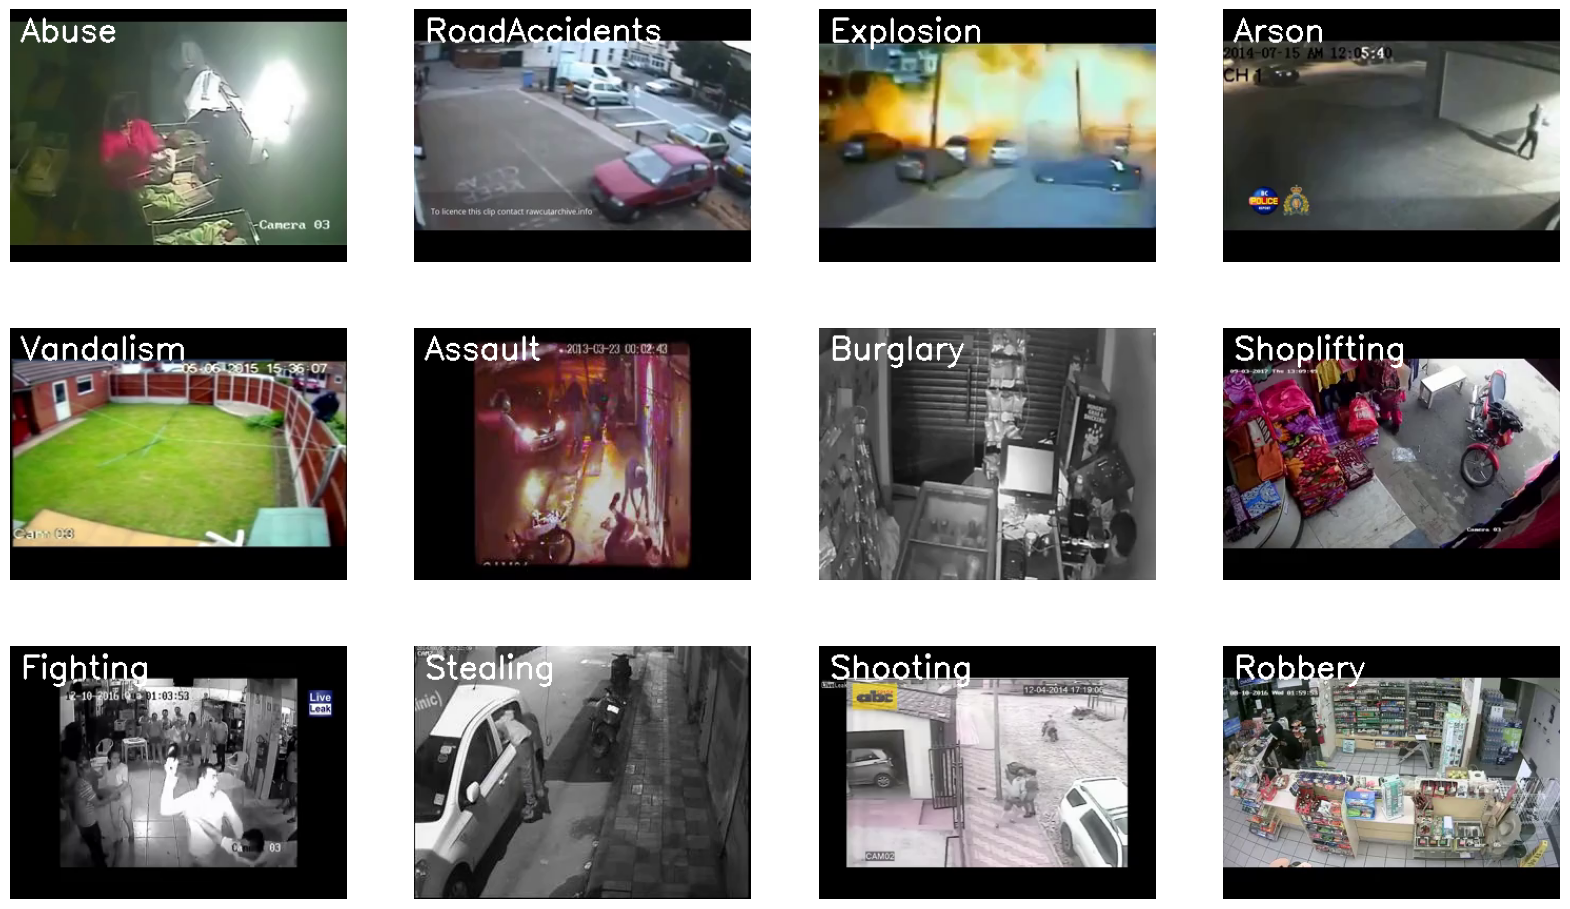

In [ ]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('/content/video_data')

# Generate a list of 20 random values. The values will be between 0-50,
# where 50 is the total number of class in the dataset.
random_range = random.sample(range(len(all_classes_names)), 12)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'/content/video_data/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'/content/video_data/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [ ]:
os.listdir('/content/video_data')

['Burglary',
 'Assault',
 'Shoplifting',
 'Vandalism',
 'Explosion',
 'Stealing',
 'Arrest',
 'RoadAccidents',
 'Robbery',
 'Fighting',
 'Abuse',
 'Shooting',
 'Arson']

In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "/content/video_data/"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ['Arrest',
 'Abuse',
 'Arson',
 'RoadAccidents',
 'Robbery',
 'Assault',
 'Stealing',
 'Shoplifting',
 'Explosion',
 'Vandalism',
 'Burglary',
 'Shooting',
 'Fighting']

In [ ]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

In [ ]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [ ]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Arrest
Extracting Data of Class: Abuse
Extracting Data of Class: Arson
Extracting Data of Class: RoadAccidents
Extracting Data of Class: Robbery
Extracting Data of Class: Assault
Extracting Data of Class: Stealing
Extracting Data of Class: Shoplifting
Extracting Data of Class: Explosion
Extracting Data of Class: Vandalism
Extracting Data of Class: Burglary
Extracting Data of Class: Shooting
Extracting Data of Class: Fighting


In [ ]:
features.shape

(650, 20, 64, 64, 3)

In [ ]:
labels.shape

(650,)

In [ ]:
video_files_paths

['/content/video_data/Arrest/Arrest036_x264_27.mp4',
 '/content/video_data/Arrest/Arrest036_x264_9.mp4',
 '/content/video_data/Arrest/Arrest003_x264_28.mp4',
 '/content/video_data/Arrest/Arrest040_x264_23.mp4',
 '/content/video_data/Arrest/Arrest003_x264_18.mp4',
 '/content/video_data/Arrest/Arrest040_x264_30.mp4',
 '/content/video_data/Arrest/Arrest036_x264_31.mp4',
 '/content/video_data/Arrest/Arrest037_x264_30.mp4',
 '/content/video_data/Arrest/Arrest040_x264_22.mp4',
 '/content/video_data/Arrest/Arrest003_x264_20.mp4',
 '/content/video_data/Arrest/Arrest036_x264_11.mp4',
 '/content/video_data/Arrest/Arrest037_x264_6.mp4',
 '/content/video_data/Arrest/Arrest037_x264_31.mp4',
 '/content/video_data/Arrest/Arrest003_x264_12.mp4',
 '/content/video_data/Arrest/Arrest003_x264_22.mp4',
 '/content/video_data/Arrest/Arrest036_x264_15.mp4',
 '/content/video_data/Arrest/Arrest037_x264_7.mp4',
 '/content/video_data/Arrest/Arrest036_x264_18.mp4',
 '/content/video_data/Arrest/Arrest036_x264_13.mp

In [ ]:
one_hot_encoded_labels = tf.keras.utils.to_categorical(labels)

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)

In [ ]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = tf.keras.Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(tf.keras.layers.ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2)))

    model.add(tf.keras.layers.ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2)))

    model.add(tf.keras.layers.ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2)))

    model.add(tf.keras.layers.ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(len(CLASSES_LIST), activation = "softmax"))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

In [ ]:
convlstm_model = create_convlstm_model()
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

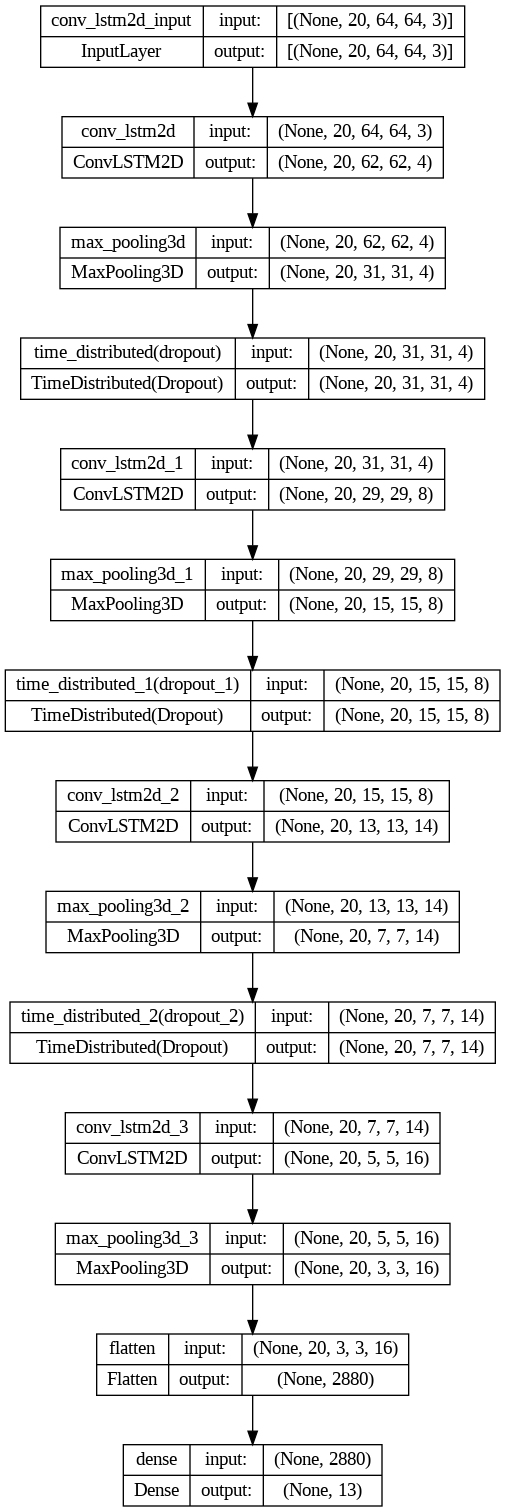

In [ ]:
# Plot the structure of the contructed model.
tf.keras.utils.plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 5, batch_size = 4,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/5
98/98 [==============================] - 88s 649ms/step - loss: 2.5381 - accuracy: 0.1337 - val_loss: 2.3653 - val_accuracy: 0.1735
Epoch 2/5
98/98 [==============================] - 54s 548ms/step - loss: 1.6873 - accuracy: 0.4781 - val_loss: 1.1044 - val_accuracy: 0.8265
Epoch 3/5
98/98 [==============================] - 53s 541ms/step - loss: 0.7190 - accuracy: 0.8021 - val_loss: 0.5828 - val_accuracy: 0.8980
Epoch 4/5
98/98 [==============================] - 51s 516ms/step - loss: 0.3101 - accuracy: 0.9100 - val_loss: 0.6101 - val_accuracy: 0.8980
Epoch 5/5
98/98 [==============================] - 52s 531ms/step - loss: 0.1750 - accuracy: 0.9512 - val_loss: 0.5444 - val_accuracy: 0.9388


In [ ]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

6/6 [==============================] - 1s 95ms/step - loss: 0.5056 - accuracy: 0.8896


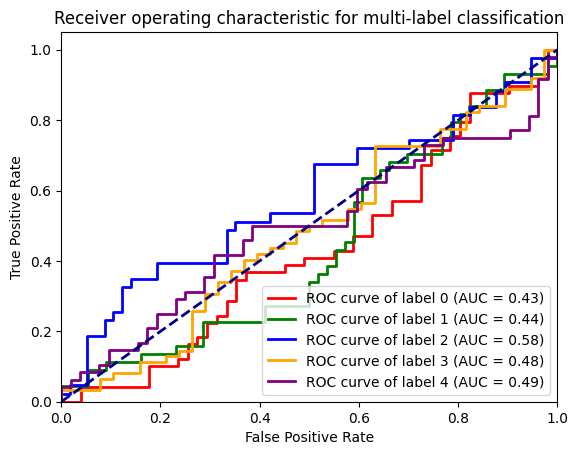

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Generate random labels and predicted probabilities for a multi-label classification problem
labels_test = np.random.randint(low=0, high=2, size=(100, 5))
pred_prob = np.random.rand(100, 5)

# Calculate false positive rate, true positive rate, and thresholds for each label
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(labels_test.shape[1]):
    fpr[i], tpr[i], thresholds = roc_curve(labels_test[:, i], pred_prob[:, i])
    roc_auc[i] = roc_auc_score(labels_test[:, i], pred_prob[:, i])

# Plot ROC curves for each label
plt.figure()
lw = 2
colors = ['red', 'green', 'blue', 'orange', 'purple']
for i, color in zip(range(labels_test.shape[1]), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of label {0} (AUC = {1:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-label classification')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# import itertools
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix

# # Get predicted labels for the test data
# pred_labels = np.argmax(convlstm_model.predict(features_test), axis=1)

# # Compute confusion matrix
# cm = confusion_matrix(np.argmax(labels_test, axis=1), pred_labels)

# # Plot confusion matrix
# plt.figure(figsize=(8,8))
# plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# plt.title("Confusion Matrix")
# plt.colorbar()
# tick_marks = np.arange(len(CLASSES_LIST))
# plt.xticks(tick_marks, CLASSES_LIST, rotation=90)
# plt.yticks(tick_marks, CLASSES_LIST)

# # Normalize the confusion matrix
# cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

# # Use white text if squares are dark; otherwise black
# text_color = "white" if cm.max() > 0.5 else "black"

# # Add labels to the plot
# thresh = cm.max() / 2.
# for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#     plt.text(j, i, cm[i, j], horizontalalignment="center", color=text_color)

# plt.tight_layout()
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.show()


In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model_{current_date_time_string}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

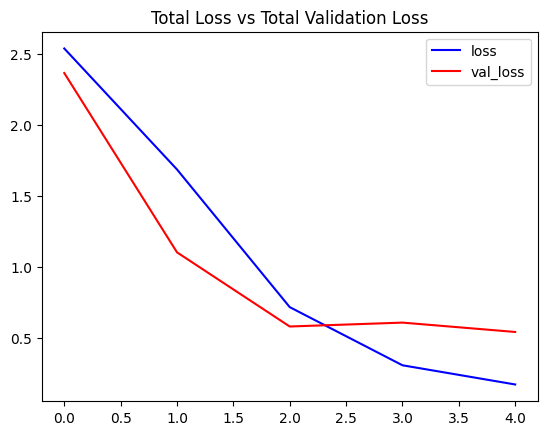

In [ ]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

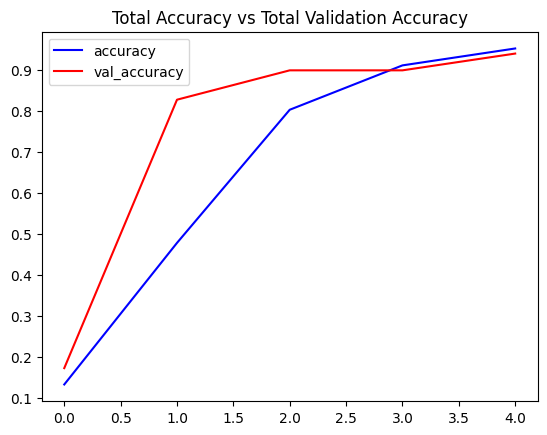

In [ ]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
!pip install mediapy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

In [ ]:
CLASSES_LIST

['Arrest',
 'Abuse',
 'Arson',
 'RoadAccidents',
 'Robbery',
 'Assault',
 'Stealing',
 'Shoplifting',
 'Explosion',
 'Vandalism',
 'Burglary',
 'Shooting',
 'Fighting']

In [ ]:
def vid_class_pred(path,class_list):
    arr = np.array(frames_extraction(path))
    arr = np.expand_dims(arr, axis=0)
    model_pred = convlstm_model.predict(arr).ravel()
    pred_prob = max(model_pred)
    pred_class = class_list[np.argmax(model_pred)]
    return pred_class,pred_prob

In [ ]:
import mediapy as media
vid_path = '/content/video_data/RoadAccidents/RoadAccidents079_x264_28.mp4'

video = media.read_video(vid_path)
media.show_video(video, fps=30)

In [ ]:
pred,prob = vid_class_pred(vid_path,CLASSES_LIST)
pred,prob

1/1 [==============================] - 0s 54ms/step


('RoadAccidents', 0.9968622)